# Xception Model Training

This notebook contains model training process for Xception model on three different deepfake detection datasets. The model training splitted into two parts, which are baseline model (base model without dropout) and the dropout model itself.

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception, xception
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt
import pickle
import os

## Define Dataset Directory

In [2]:
CDF_DATASET_DIR = "/kaggle/input/deepfake-detection-datasets/Celeb-DF-v2"
DF_DATASET_DIR = "/kaggle/input/deepfake-detection-datasets/DeeperForensics-1.0"
DFDC_DATASET_DIR = "/kaggle/input/deepfake-detection-datasets/DFDC"

In [3]:
cdf_train_dir = os.path.join(CDF_DATASET_DIR, "Train")
cdf_val_dir = os.path.join(CDF_DATASET_DIR, "Val")

df_train_dir = os.path.join(DF_DATASET_DIR, "Train")
df_val_dir = os.path.join(DF_DATASET_DIR, "Val")

dfdc_train_dir = os.path.join(DFDC_DATASET_DIR, "Train")
dfdc_val_dir = os.path.join(DFDC_DATASET_DIR, "Val")

## Image Data Generator for Each Dataset

In [4]:
def create_image_generator(dataset_dir):
    datagen = ImageDataGenerator(preprocessing_function=xception.preprocess_input)
    image_generator = datagen.flow_from_directory(
        dataset_dir,
        target_size=(128, 128),
        batch_size=32,
        color_mode="rgb",
        class_mode="binary",
        shuffle=True,
        seed=42
    )

    return image_generator

In [5]:
print("Celeb-DF-v2 Dataset")
cdf_train_generator = create_image_generator(cdf_train_dir)
cdf_val_generator = create_image_generator(cdf_val_dir)

print("\nDeeperForensics-1.0 Dataset")
df_train_generator = create_image_generator(df_train_dir)
df_val_generator = create_image_generator(df_val_dir)

print("\nDeepfake Detection Challenge Dataset")
dfdc_train_generator = create_image_generator(dfdc_train_dir)
dfdc_val_generator = create_image_generator(dfdc_val_dir)

Celeb-DF-v2 Dataset
Found 14000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.

DeeperForensics-1.0 Dataset
Found 14000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.

Deepfake Detection Challenge Dataset
Found 14000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


## Get the Best Hyperparameters from Tuner

In [6]:
TUNER_RESULT_DIR = "/kaggle/input/hp-tuning/tuner-result"
TUNER_PROJECT_NAME = "cnn-best-hp"

In [7]:
tuner = kt.Hyperband(directory=TUNER_RESULT_DIR,
                     project_name=TUNER_PROJECT_NAME,
                     objective="val_accuracy",
                     overwrite=False)

Reloading Tuner from /kaggle/input/hp-tuning/tuner-result/cnn-best-hp/tuner0.json


In [8]:
best_hp = tuner.get_best_hyperparameters()[0].values
best_hp

{'conv_layers': 6,
 'conv_1_filters': 256,
 'conv_2_filters': 32,
 'conv_3_filters': 160,
 'conv_1_kernel_size': 3,
 'conv_2_kernel_size': 5,
 'conv_3_kernel_size': 5,
 'dense_layers': 6,
 'dense_1_layer_units': 128,
 'dense_2_layer_units': 96,
 'dropout_rate': 0.6000000000000001,
 'learning_rate': 1e-05,
 'dense_3_layer_units': 96,
 'dense_4_layer_units': 96,
 'dense_5_layer_units': 64,
 'conv_4_filters': 128,
 'conv_4_kernel_size': 5,
 'conv_5_filters': 192,
 'conv_6_filters': 128,
 'conv_7_filters': 224,
 'conv_5_kernel_size': 5,
 'conv_6_kernel_size': 5,
 'conv_7_kernel_size': 3,
 'dense_6_layer_units': 128,
 'dense_7_layer_units': 32,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 7,
 'tuner/bracket': 1,
 'tuner/round': 1,
 'tuner/trial_id': '0023'}

## Function to Create an Xception Model

In [9]:
def create_xception_model(hp, dropout=False, name="xception_model"):
    base_model = Xception(include_top=False, weights="imagenet", input_shape=(128, 128, 3))
    for layer in base_model.layers:
        layer.trainable = False

    model = tf.keras.Sequential(name=name)
    model.add(tf.keras.layers.Input(shape=(128, 128, 3)))
    model.add(base_model)
    model.add(tf.keras.layers.Flatten(name="flatten"))

    for i in range(hp.get("dense_layers")):
        dense_units = hp.get(f"dense_{i+1}_layer_units")
        model.add(
            tf.keras.layers.Dense(dense_units, activation="relu", name=f"dense_{i+1}")
        )

    if dropout:
        model.add(tf.keras.layers.Dropout(hp.get("dropout_rate"), name="dropout"))

    model.add(tf.keras.layers.Dense(1, activation="sigmoid", name="output"))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.get("learning_rate")),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=["accuracy"]
    )

    return model

## Function to Plot Train Results

In [10]:
def plot_train_result(history, title="Training Result"):
    plt.figure(figsize=(12, 4))
    plt.subplots_adjust(top=0.8)
    plt.suptitle(title)

    plt.subplot(1, 2, 1)
    plt.plot(history["accuracy"], label="Train")
    plt.plot(history["val_accuracy"], label="Val")
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history["loss"], label="Train")
    plt.plot(history["val_loss"], label="Val")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

## Function to Save Model Training History

In [11]:
def save_model_and_history(model, history, model_name):
    model_filename = f"{model_name}_model.keras"
    history_filename = f"{model_name}_history.pkl"

    model.save(model_filename)
    print(f"Model saved at {model_filename}")    

    with open(history_filename, "wb") as f:
        pickle.dump(history.history, f)
        print(f"Training history saved at {history_filename}")

## Model Training

In [12]:
NUM_EPOCHS = 10

### Baseline Xception

#### Celeb-DF-v2 Dataset

In [13]:
baseline_xception_cdf_model = create_xception_model(best_hp, name="baseline_xception_cdf_model")
baseline_xception_cdf_model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "baseline_xception_cdf_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 4, 4, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 96)             │        12,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,101,577 (95.75 MB)

 Trainable params: 4,240,097 (16.17 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [14]:
baseline_xception_cdf_history = baseline_xception_cdf_model.fit(
    cdf_train_generator, validation_data=cdf_val_generator, epochs=NUM_EPOCHS
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1731556826.853180     106 service.cc:145] XLA service 0x7a1678002e60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731556826.853231     106 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/438 ━━━━━━━━━━━━━━━━━━━━ 1:21:27 11s/step - accuracy: 0.4062 - loss: 0.7019

I0000 00:00:1731556831.558686     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


438/438 ━━━━━━━━━━━━━━━━━━━━ 91s 182ms/step - accuracy: 0.5767 - loss: 0.6747 - val_accuracy: 0.6270 - val_loss: 0.6634
Epoch 2/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 76s 45ms/step - accuracy: 0.7918 - loss: 0.5106 - val_accuracy: 0.6370 - val_loss: 0.7169
Epoch 3/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.8862 - loss: 0.3320 - val_accuracy: 0.6750 - val_loss: 0.6875
Epoch 4/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9302 - loss: 0.2292 - val_accuracy: 0.6690 - val_loss: 0.7776
Epoch 5/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.9467 - loss: 0.1757 - val_accuracy: 0.6865 - val_loss: 0.7590
Epoch 6/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.9636 - loss: 0.1283 - val_accuracy: 0.6715 - val_loss: 0.8188
Epoch 7/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.9717 - loss: 0.1025 - val_accuracy: 0.6810 - val_loss: 0.8450
Epoch 8/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9779 - loss: 0.0803 - val_accura

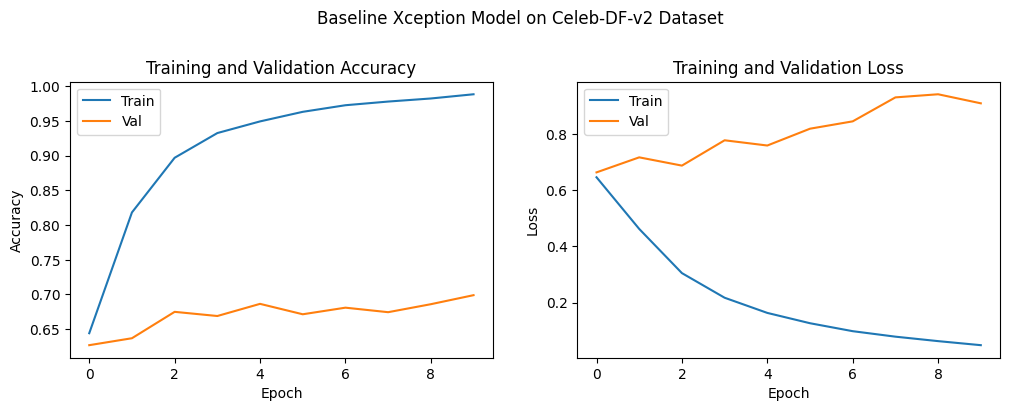

In [15]:
plot_train_result(
    baseline_xception_cdf_history.history,
    title="Baseline Xception Model on Celeb-DF-v2 Dataset"
)

In [16]:
save_model_and_history(
    baseline_xception_cdf_model, baseline_xception_cdf_history, "baseline_xception_cdf"
)

Model saved at baseline_xception_cdf_model.keras
Training history saved at baseline_xception_cdf_history.pkl


#### DeeperForensics-1.0 Dataset

In [17]:
baseline_xception_df_model = create_xception_model(best_hp, name="baseline_xception_df_model")
baseline_xception_df_model.summary()

Model: "baseline_xception_df_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 4, 4, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 96)             │        12,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,101,577 (95.75 MB)

 Trainable params: 4,240,097 (16.17 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [18]:
baseline_xception_df_history = baseline_xception_df_model.fit(
    df_train_generator, validation_data=df_val_generator, epochs=NUM_EPOCHS
)

Epoch 1/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 91s 189ms/step - accuracy: 0.7442 - loss: 0.5497 - val_accuracy: 0.7560 - val_loss: 0.4633
Epoch 2/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - accuracy: 0.9723 - loss: 0.1377 - val_accuracy: 0.7925 - val_loss: 0.4332
Epoch 3/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - accuracy: 0.9906 - loss: 0.0543 - val_accuracy: 0.8260 - val_loss: 0.3899
Epoch 4/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - accuracy: 0.9942 - loss: 0.0332 - val_accuracy: 0.8505 - val_loss: 0.3641
Epoch 5/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 23s 53ms/step - accuracy: 0.9960 - loss: 0.0212 - val_accuracy: 0.8520 - val_loss: 0.3700
Epoch 6/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 24s 55ms/step - accuracy: 0.9970 - loss: 0.0151 - val_accuracy: 0.8635 - val_loss: 0.3378
Epoch 7/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - accuracy: 0.9987 - loss: 0.0108 - val_accuracy: 0.8585 - val_loss: 0.3730
Epoch 8/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - accuracy: 0.9994 - loss: 0.0062 -

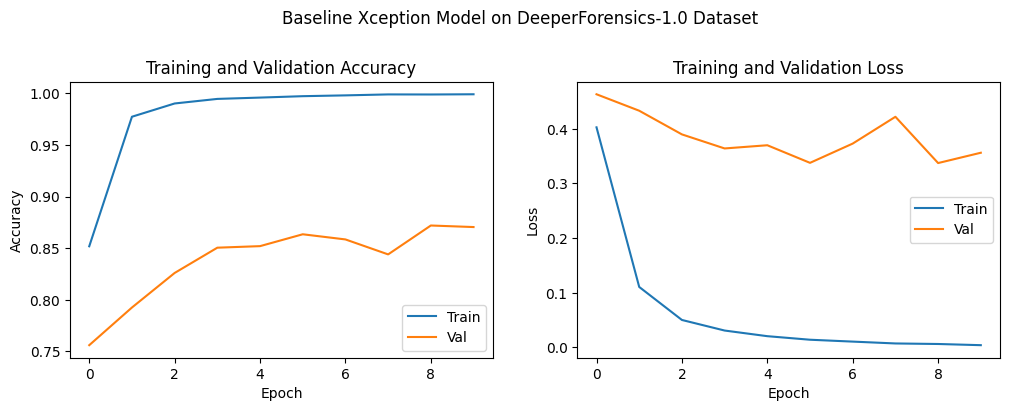

In [19]:
plot_train_result(
    baseline_xception_df_history.history,
    title="Baseline Xception Model on DeeperForensics-1.0 Dataset"
)

In [20]:
save_model_and_history(
    baseline_xception_df_model, baseline_xception_df_history, "baseline_xception_df"
)

Model saved at baseline_xception_df_model.keras
Training history saved at baseline_xception_df_history.pkl


#### DFDC Dataset

In [21]:
baseline_xception_dfdc_model = create_xception_model(best_hp, name="baseline_xception_dfdc_model")
baseline_xception_dfdc_model.summary()

Model: "baseline_xception_dfdc_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 4, 4, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 96)             │        12,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,101,577 (95.75 MB)

 Trainable params: 4,240,097 (16.17 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [22]:
baseline_xception_dfdc_history = baseline_xception_dfdc_model.fit(
    dfdc_train_generator, validation_data=dfdc_val_generator, epochs=NUM_EPOCHS
)

Epoch 1/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 103s 215ms/step - accuracy: 0.6221 - loss: 0.6603 - val_accuracy: 0.5810 - val_loss: 0.6814
Epoch 2/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 22s 49ms/step - accuracy: 0.8777 - loss: 0.3839 - val_accuracy: 0.5530 - val_loss: 0.8299
Epoch 3/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.9368 - loss: 0.2131 - val_accuracy: 0.5345 - val_loss: 1.0005
Epoch 4/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 42s 51ms/step - accuracy: 0.9657 - loss: 0.1276 - val_accuracy: 0.5345 - val_loss: 1.1066
Epoch 5/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 22s 51ms/step - accuracy: 0.9801 - loss: 0.0832 - val_accuracy: 0.5110 - val_loss: 1.2631
Epoch 6/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step - accuracy: 0.9838 - loss: 0.0613 - val_accuracy: 0.5105 - val_loss: 1.4871
Epoch 7/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 22s 49ms/step - accuracy: 0.9887 - loss: 0.0452 - val_accuracy: 0.5080 - val_loss: 1.5318
Epoch 8/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.9914 - loss: 0.0355 

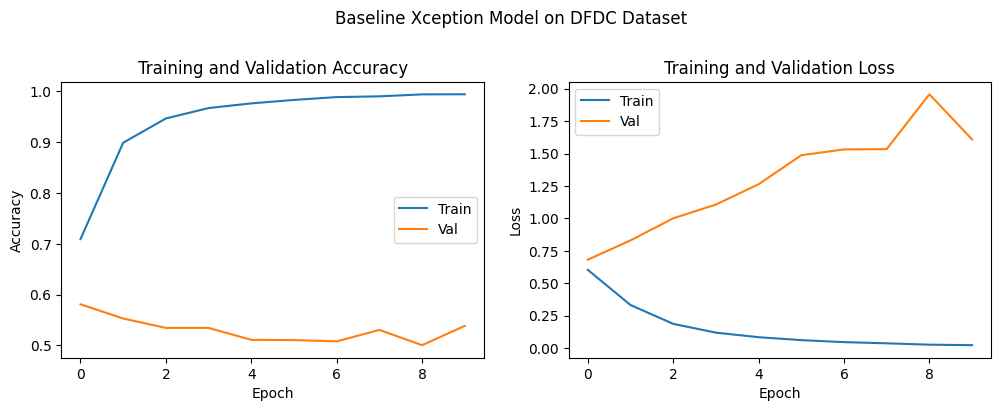

In [23]:
plot_train_result(
    baseline_xception_dfdc_history.history,
    title="Baseline Xception Model on DFDC Dataset"
)

In [24]:
save_model_and_history(
    baseline_xception_dfdc_model, baseline_xception_dfdc_history, "baseline_xception_dfdc"
)

Model saved at baseline_xception_dfdc_model.keras
Training history saved at baseline_xception_dfdc_history.pkl


### Dropout Xception Model Training

#### Celeb-DF-v2 Dataset

In [25]:
dropout_xception_cdf_model = create_xception_model(best_hp, dropout=True, name="dropout_xception_cdf_model")
dropout_xception_cdf_model.summary()

Model: "dropout_xception_cdf_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 4, 4, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 96)             │        12,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,101,577 (95.75 MB)

 Trainable params: 4,240,097 (16.17 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [26]:
dropout_xception_cdf_history = dropout_xception_cdf_model.fit(
    cdf_train_generator, validation_data=cdf_val_generator, epochs=NUM_EPOCHS
)

Epoch 1/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 48s 88ms/step - accuracy: 0.5489 - loss: 0.6856 - val_accuracy: 0.6090 - val_loss: 0.6620
Epoch 2/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.7382 - loss: 0.5845 - val_accuracy: 0.6605 - val_loss: 0.6457
Epoch 3/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.8517 - loss: 0.4145 - val_accuracy: 0.6690 - val_loss: 0.6667
Epoch 4/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9088 - loss: 0.2846 - val_accuracy: 0.6690 - val_loss: 0.7249
Epoch 5/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.9355 - loss: 0.2084 - val_accuracy: 0.6670 - val_loss: 0.7524
Epoch 6/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 22s 50ms/step - accuracy: 0.9513 - loss: 0.1585 - val_accuracy: 0.6650 - val_loss: 0.8447
Epoch 7/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 22s 49ms/step - accuracy: 0.9647 - loss: 0.1218 - val_accuracy: 0.6860 - val_loss: 0.7969
Epoch 8/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 23s 52ms/step - accuracy: 0.9745 - loss: 0.0910 - 

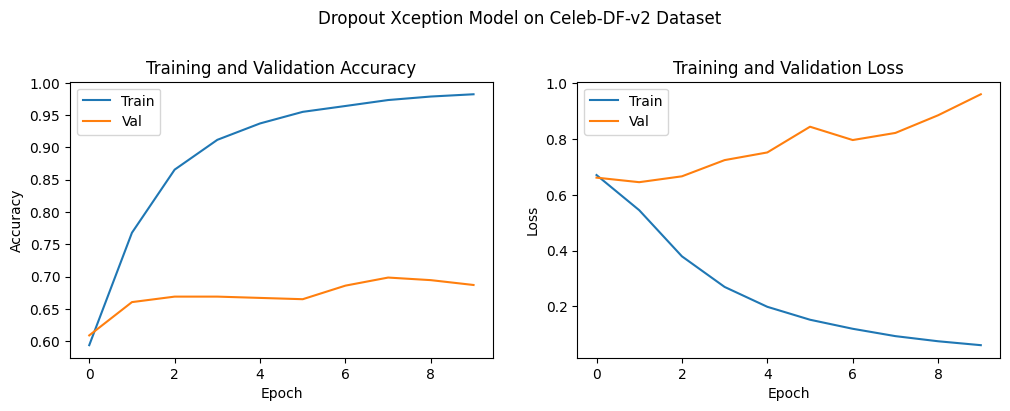

In [27]:
plot_train_result(
    dropout_xception_cdf_history.history,
    title="Dropout Xception Model on Celeb-DF-v2 Dataset"
)

In [28]:
save_model_and_history(
    dropout_xception_cdf_model, dropout_xception_cdf_history, "dropout_xception_cdf"
)

Model saved at dropout_xception_cdf_model.keras
Training history saved at dropout_xception_cdf_history.pkl


#### DeeperForensics-1.0 Dataset

In [29]:
dropout_xception_df_model = create_xception_model(best_hp, dropout=True, name="dropout_xception_df_model")
dropout_xception_df_model.summary()

Model: "dropout_xception_df_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 4, 4, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 96)             │        12,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,101,577 (95.75 MB)

 Trainable params: 4,240,097 (16.17 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [30]:
dropout_xception_df_history = dropout_xception_df_model.fit(
    df_train_generator, validation_data=df_val_generator, epochs=NUM_EPOCHS
)

Epoch 1/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 51s 95ms/step - accuracy: 0.6642 - loss: 0.6163 - val_accuracy: 0.7015 - val_loss: 0.5316
Epoch 2/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 24s 55ms/step - accuracy: 0.9401 - loss: 0.2216 - val_accuracy: 0.7855 - val_loss: 0.4395
Epoch 3/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 23s 53ms/step - accuracy: 0.9768 - loss: 0.0977 - val_accuracy: 0.7945 - val_loss: 0.4744
Epoch 4/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - accuracy: 0.9874 - loss: 0.0555 - val_accuracy: 0.8290 - val_loss: 0.4219
Epoch 5/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 25s 56ms/step - accuracy: 0.9919 - loss: 0.0379 - val_accuracy: 0.8335 - val_loss: 0.4267
Epoch 6/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 23s 53ms/step - accuracy: 0.9946 - loss: 0.0273 - val_accuracy: 0.8690 - val_loss: 0.3441
Epoch 7/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - accuracy: 0.9964 - loss: 0.0166 - val_accuracy: 0.8405 - val_loss: 0.4550
Epoch 8/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 23s 53ms/step - accuracy: 0.9976 - loss: 0.0130 - 

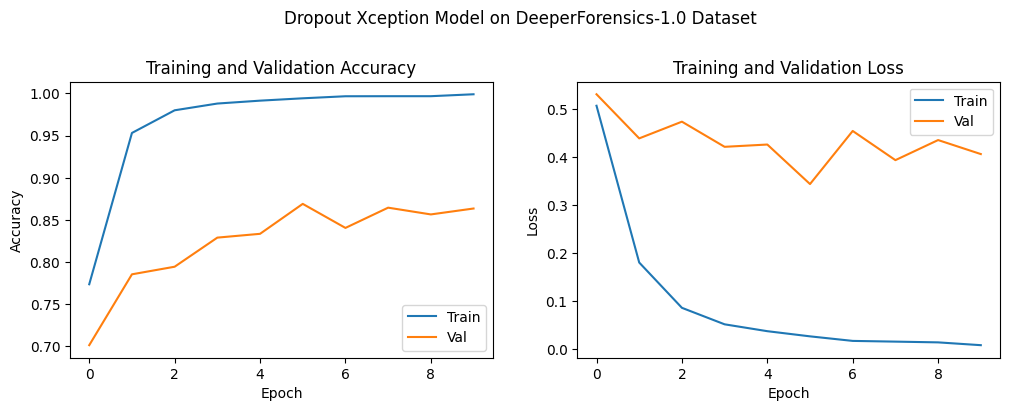

In [31]:
plot_train_result(
    dropout_xception_df_history.history,
    title="Dropout Xception Model on DeeperForensics-1.0 Dataset"
)

In [32]:
save_model_and_history(
    dropout_xception_df_model, dropout_xception_df_history, "dropout_xception_df"
)

Model saved at dropout_xception_df_model.keras
Training history saved at dropout_xception_df_history.pkl


#### DFDC Dataset

In [33]:
dropout_xception_dfdc_model = create_xception_model(best_hp, dropout=True, name="dropout_xception_dfdc_model")
dropout_xception_dfdc_model.summary()

Model: "dropout_xception_dfdc_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 4, 4, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 96)             │        12,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,101,577 (95.75 MB)

 Trainable params: 4,240,097 (16.17 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [34]:
dropout_xception_dfdc_history = dropout_xception_dfdc_model.fit(
    dfdc_train_generator, validation_data=dfdc_val_generator, epochs=NUM_EPOCHS
)

Epoch 1/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 42s 76ms/step - accuracy: 0.5749 - loss: 0.6686 - val_accuracy: 0.5660 - val_loss: 0.6753
Epoch 2/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 22s 49ms/step - accuracy: 0.8177 - loss: 0.4727 - val_accuracy: 0.5685 - val_loss: 0.7435
Epoch 3/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.9175 - loss: 0.2782 - val_accuracy: 0.5595 - val_loss: 0.8611
Epoch 4/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.9423 - loss: 0.1865 - val_accuracy: 0.5385 - val_loss: 0.9994
Epoch 5/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.9658 - loss: 0.1237 - val_accuracy: 0.5145 - val_loss: 1.2315
Epoch 6/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.9765 - loss: 0.0904 - val_accuracy: 0.5255 - val_loss: 1.2074
Epoch 7/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 22s 49ms/step - accuracy: 0.9811 - loss: 0.0753 - val_accuracy: 0.5080 - val_loss: 1.4887
Epoch 8/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 22s 50ms/step - accuracy: 0.9858 - loss: 0.0542 - 

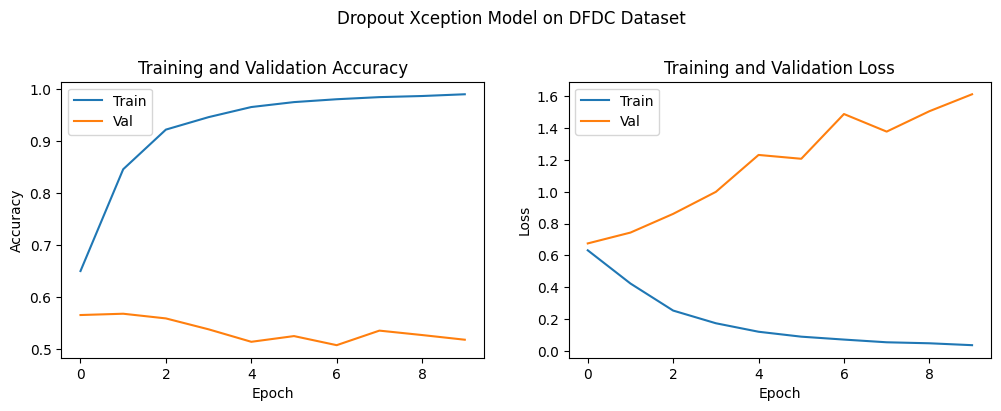

In [35]:
plot_train_result(
    dropout_xception_dfdc_history.history,
    title="Dropout Xception Model on DFDC Dataset"
)

In [36]:
save_model_and_history(
    dropout_xception_dfdc_model, dropout_xception_dfdc_history, "dropout_xception_dfdc"
)

Model saved at dropout_xception_dfdc_model.keras
Training history saved at dropout_xception_dfdc_history.pkl
